In [1]:
from urllib.request import urlopen
import requests,json,os,sys,time,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import ast
import unicodedata
import itertools
import seaborn as sns
from collections import Counter
import datetime
import statistics as st
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.cluster import DBSCAN

In [2]:
def plot_distortion(X,label,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o', label = label)
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.legend()

In [3]:
 def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        
        #print(cluster)
        #print(y_res == cluster)
        
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=100,
                    marker='.',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='black',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
data_path = '/mnt/d/lighthouse/Final_data/'
games = pd.read_csv(data_path +'game_df_2.csv', header = 0)
games.drop('Unnamed: 0', axis = 1, inplace = True)
# game_dota = pd.read_csv(data_path +'game_with_dota.csv', header = 0)
# game_dota.drop('Unnamed: 0', axis = 1, inplace = True)

# Game DF

In [5]:
# with open('game_data.pkl', 'rb') as f:
#     new_game_data = pickle.load(f)
# game_columns = list(new_game_data[0]['4000']['data'].keys())

In [5]:
games.drop_duplicates(subset ="steam_appid", keep = 'first', inplace = True)

In [7]:
# user_game_data = pd.concat([games,game_dota])
# user_game_data.shape

In [8]:
# user_game_data.drop_duplicates(subset ="steam_appid", keep = 'first', inplace = True)
# user_game_data.shape
# user_game_data.to_csv('/mnt/d/lighthouse/Final_data/game_df_2.csv')

In [6]:
# 31201 rows × 40 columns
games

type                                  name  steam_appid  required_age  \
0      game                           Garry's Mod         4000             0   
1      game  Vampire: The Masquerade - Bloodlines         2600            17   
2      game                         Killing Floor         1250            17   
3       mod                    Defence Alliance 2        35420             0   
4      game           Bad Rats: the Rats' Revenge        34900             0   
...     ...                                   ...          ...           ...   
31196  game                       Space Scavenger      1040460             0   
31197  game                          Love n Dream      1303740             0   
31198  game         Just Cause 2: Multiplayer Mod       259080            17   
31199   mod                      Estranged: Act I       261820             0   
31200   mod                     Half-Life: Before       261980             0   

       is_free controller_support  \
0        False                NaN   
1        False                NaN   
2        False                NaN   
3         True                NaN   
4        False                NaN   
...        ...                ...   
31196    False               full   
31197    False                NaN   
31198     True                NaN   
31199     True                NaN   
31200     True                NaN   

                                                     dlc  \
0                                                    NaN   
1                                                    NaN   
2      [258750, 258751, 258752, 210943, 210944, 21094...   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
31196                                                NaN   
31197                                          [1356850]   
31198                                                NaN   
31199                                                NaN   
31200                                                NaN   

                                    detailed_description  \
0      Garry's Mod is a physics sandbox. There aren't...   
1      Vampire®: The Masquerade-Bloodlines™ delivers ...   
2      Killing Floor is a Co-op Survival Horror FPS s...   
3      \n\t\t\t\t\t<p>Defence Alliance 2 is a total c...   
4      Bad Rats is a physics puzzle game where rats f...   
...                                                  ...   
31196  <h2 class="bb_tag">Build and design as you go ...   
31197  <h1>❤ COMING SOON ❤ LOVE TAVERN</h1><p><a href...   
31198  JC2-MP is a project to bring multiplayer to Ju...   
31199  Estranged tells the story of a lone fisherman,...   
31200  Half-Life: Before – is a modification for Half...   

                                          about_the_game  \
0      Garry's Mod is a physics sandbox. There aren't...   
1      Vampire®: The Masquerade-Bloodlines™ delivers ...   
2      Killing Floor is a Co-op Survival Horror FPS s...   
3      \n\t\t\t\t\t<p>Defence Alliance 2 is a total c...   
4      Bad Rats is a physics puzzle game where rats f...   
...                                                  ...   
31196  <h2 class="bb_tag">Build and design as you go ...   
31197  <img src="https://steamcdn-a.akamaihd.net/stea...   
31198  JC2-MP is a project to bring multiplayer to Ju...   
31199  Estranged tells the story of a lone fisherman,...   
31200  Half-Life: Before – is a modification for Half...   

                                       short_description  ...  \
0      Garry's Mod is a physics sandbox. There aren't...  ...   
1      Vampire®: The Masquerade-Bloodlines™ delivers ...  ...   
2      6-player co-op survival horror at its finest! ...  ...   
3      Defence Alliance 2 is a total conversion mod f...  ...   
4      Bad Rats is a physics puzzle game where rats f...  ...   
...                                             

In [7]:
game_id_dict = pd.Series(games.name.values,index=games.steam_appid).to_dict()

In [8]:
total = games.isnull().sum().sort_values(ascending=False)
percentage = (games.isnull().sum()/games.isnull().count()).sort_values(ascending=False)
sum_table = pd.concat([total,percentage], axis = 1, keys=['Total', 'Percent'])
to_drop = list(sum_table[sum_table['Percent']>0.8].index)

sum_table

Total   Percent
alternate_appid          31164  0.998814
drm_notice               30990  0.993237
ext_user_account_notice  30701  0.983975
demos                    29046  0.930932
metacritic               27747  0.889298
fullgame                 26343  0.844300
dlc                      25737  0.824877
reviews                  25048  0.802795
recommendations          22303  0.714817
legal_notice             20627  0.661101
controller_support       19951  0.639435
achievements             16050  0.514407
website                  12750  0.408641
price_overview            7065  0.226435
movies                    6775  0.217140
packages                  6240  0.199994
genres                    5042  0.161597
developers                4929  0.157976
detailed_description      4751  0.152271
about_the_game            4751  0.152271
screenshots               4726  0.151470
background                4726  0.151470
categories                 517  0.016570
supported_languages        119  0.003814
short_description           76  0.002436
name                         2  0.000064
steam_appid                  0  0.000000
required_age                 0  0.000000
is_free                      0  0.000000
content_descriptors          0  0.000000
package_groups               0  0.000000
publishers                   0  0.000000
support_info                 0  0.000000
header_image                 0  0.000000
release_date                 0  0.000000
pc_requirements              0  0.000000
mac_requirements             0  0.000000
linux_requirements           0  0.000000
platforms                    0  0.000000
type                         0  0.000000

# Fill NA

In [9]:
pd.set_option('display.max_columns', None)
clean_game = copy.deepcopy(games)
clean_game.drop(to_drop, axis =1, inplace=True)
clean_game.drop(['legal_notice', 'background', 'support_info','detailed_description','short_description','about_the_game','header_image','pc_requirements', 'mac_requirements', 'linux_requirements','package_groups','content_descriptors'], axis =1, inplace=True)
clean_game = clean_game[clean_game['name'].isnull()==False]
clean_game.head()

type                                  name  steam_appid  required_age  \
0  game                           Garry's Mod         4000             0   
1  game  Vampire: The Masquerade - Bloodlines         2600            17   
2  game                         Killing Floor         1250            17   
3   mod                    Defence Alliance 2        35420             0   
4  game           Bad Rats: the Rats' Revenge        34900             0   

   is_free controller_support  \
0    False                NaN   
1    False                NaN   
2    False                NaN   
3     True                NaN   
4    False                NaN   

                                 supported_languages  \
0  English<strong>*</strong>, French, Italian, Ge...   
1                            English, French, German   
2  English<strong>*</strong>, French<strong>*</st...   
3                                            English   
4                                            English   

                              website                 developers  \
0           http://gmod.facepunch.com      ['Facepunch Studios']   
1    http://www.vampirebloodlines.com           ['Troika Games']   
2  http://www.killingfloorthegame.com   ['Tripwire Interactive']   
3  http://www.defencealliancegame.com  ['Defence Alliance Team']   
4         http://www.invent4.com/rats  ['Invent4 Entertainment']   

                 publishers  \
0                 ['Valve']   
1            ['Activision']   
2  ['Tripwire Interactive']   
3  ['Tripwire Interactive']   
4        ['Strategy First']   

                                      price_overview       packages  \
0  {'currency': 'CAD', 'initial': 1099, 'final': ...  [218, 295508]   
1  {'currency': 'CAD', 'initial': 2199, 'final': ...          [288]   
2  {'currency': 'CAD', 'initial': 2199, 'final': ...         [1579]   
3                                                NaN            NaN   
4  {'currency': 'CAD', 'initial': 109, 'final': 1...         [1861]   

                                         platforms  \
0    {'windows': True, 'mac': True, 'linux': True}   
1  {'windows': True, 'mac': False, 'linux': False}   
2    {'windows': True, 'mac': True, 'linux': True}   
3  {'windows': True, 'mac': False, 'linux': False}   
4  {'windows': True, 'mac': False, 'linux': False}   

                                          categories  \
0  [{'id': 2, 'description': 'Single-player'}, {'...   
1        [{'id': 2, 'description': 'Single-player'}]   
2  [{'id': 2, 'description': 'Single-player'}, {'...   
3  [{'id': 2, 'description': 'Single-player'}, {'...   
4  [{'id': 2, 'description': 'Single-player'}, {'...   

                                              genres  \
0  [{'id': '23', 'description': 'Indie'}, {'id': ...   
1             [{'id': '1', 'description': 'Action'}]   
2             [{'id': '1', 'description': 'Action'}]   
3             [{'id': '1', 'description': 'Action'}]   
4             [{'id': '23', 'description': 'Indie'}]   

                                         screenshots  \
0  [{'id': 0, 'path_thumbnail': 'https://steamcdn...   
1  [{'id': 0, 'path_thumbnail': 'https://steamcdn...   
2  [{'id': 0, 'path_thumbnail': 'https://steamcdn...   
3  [{'id': 0, 'path_thumbnail': 'https://steamcdn...   
4  [{'id': 0, 'path_thumbnail': 'https://steamcdn...   

                                              movies    recommendations  \
0                                                NaN  {'total': 508409}   
1                                                NaN    {'total': 7760}   
2  [{'id': 5243, 'name': 'Killing Floor Launch Tr...   {'total': 33832}   
3                                                NaN     {'total': 466}   
4                                                NaN    {'total': 6649}   

                                        achievements  \
0  {'total': 29, 'highlighted': [{'name': 'Play S...   
1                                                NaN   
2  {'total': 285, 'highlighted':

In [10]:
total = clean_game.isnull().sum().sort_values(ascending=False)
percentage = (clean_game.isnull().sum()/clean_game.isnull().count()).sort_values(ascending=False)
sum_table = pd.concat([total,percentage], axis = 1, keys=['Total', 'Percent'])

sum_table.head(5)

Total   Percent
recommendations     22301  0.714799
controller_support  19949  0.639412
achievements        16048  0.514375
website             12748  0.408603
price_overview       7063  0.226385

In [11]:
clean_game['supported_languages'] = clean_game['supported_languages'].fillna('English')
clean_game['categories'] = clean_game['categories'].fillna('[]')
clean_game['screenshots'] = clean_game['screenshots'].fillna('[]')
clean_game['developers'] = clean_game['developers'].fillna('[]')
clean_game['genres'] = clean_game['genres'].fillna('[]')
clean_game['packages'] = clean_game['packages'].fillna('[]')
clean_game['movies'] = clean_game['movies'].fillna('[]')
clean_game['price_overview'] = clean_game['price_overview'].fillna("{'currency': 'CAD', 'initial': 0, 'final': 0, 'discount_percent': 0, 'initial_formatted': '', 'final_formatted': 'CDN$ 0'}")
clean_game['website'] = clean_game['website'].fillna(0)
clean_game['achievements'] = clean_game['achievements'].fillna("{'total': 0}")
clean_game['controller_support'] = clean_game['controller_support'].fillna('None')
clean_game['recommendations'] = clean_game['recommendations'].fillna("{'total': 0}")

# FE

#### Supported Language

In [12]:
all_languages = ['Arabic','Bulgarian','Simplified Chinese','Traditional Chinese','Czech','Danish','Dutch','English',
'Finnish','French','German','Greek','Hungarian','Italian','Japanese','Korean','Norwegian','Polish','Portuguese',
'Portuguese Brazil','Romanian','Russian','Spanish Spain','Spanish-Latin America','Swedish','Thai','Turkish','Ukrainian','Vietnamese']
all_languages = [x.lower() for x in all_languages]

In [13]:
#clean_game['supported_languages'][3293]

In [14]:
def clean_supported_language(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    cleantext = cleantext.replace('*', '')
    cleantext = cleantext.replace('languages with full audio support', '')
    cleantext = cleantext.lower()
    cleantext = cleantext.strip()
    return cleantext

In [15]:
def intersperse(lst, item):
    result = [item] * (len(lst) * 2 - 1)
    result[0::2] = lst
    result.append(item)
    return result

In [16]:
def convert_to_dict(x, item):
    testing = intersperse(x, item)
    d = dict(itertools.zip_longest(*[iter(testing)] * 2, fillvalue=""))
    return d

In [17]:
def num_languages(x):
    total_lan = 0
    for i in all_languages:
        if i in x:
            total_lan += 1
        else:
            next
    return total_lan

In [18]:
def languages(x):
    d = convert_to_dict(all_languages, 0)
    for i in all_languages:
        if i in x:
            d[i] = 1
        else:
            next
    return d

In [19]:
clean_game['supported_languages'] = clean_game['supported_languages'].apply(lambda x : clean_supported_language(x))
clean_game['supported_languages'] = clean_game['supported_languages'].apply(lambda x : languages(x))
#lang = clean_game['supported_languages'].apply(pd.Series)
#clean_game = pd.concat([clean_game, lang], axis=1)
#clean_game.drop('supported_languages', axis = 1, inplace=True)

In [20]:
lang_1=['english']  
lang_2=['german', 'french','russian', 'italian', 'japanese']
lang_3=['bulgarian', 'simplified chinese', 'traditional chinese', 'czech','danish', 'dutch', 'finnish', 'greek', 'hungarian', 'korean', 'norwegian', 'polish',
       'portuguese', 'swedish', 'thai', 'turkish', 'ukrainian','romanian', 'vietnamese', 'arabic']
lang_groups = []
for i in clean_game['supported_languages']:
    cur_dict = {'lang_1':0,'lang_2':0,'lang_3':0}
    for name, bol in i.items():
        if (bol == 1) & (name in lang_1):
            cur_dict['lang_1'] = cur_dict['lang_1'] + 1
        elif (bol == 1) & (name in lang_2):
            cur_dict['lang_2'] = cur_dict['lang_2'] + 1
        elif (bol == 1) & (name in lang_3):
            cur_dict['lang_3'] = cur_dict['lang_3'] + 1
        else:
            next
    lang_groups.append(cur_dict)

In [21]:
lang_group_df = pd.DataFrame(lang_groups)
lang_group_df.index = clean_game.steam_appid
lang_group_df

lang_1  lang_2  lang_3
steam_appid                        
4000              1       5      17
2600              1       2       0
1250              1       4       2
35420             1       0       0
34900             1       0       0
...             ...     ...     ...
1040460           1       3       3
1303740           1       1       2
259080            1       4       1
261820            1       5      19
261980            1       0       0

[31199 rows x 3 columns]

In [22]:
lang_dict = {}
for i in clean_game['supported_languages']:
    lang_dict = Counter(lang_dict) + Counter(i)
languages =  pd.DataFrame.from_dict(lang_dict,orient='index', columns=['count'])

In [23]:
fig = px.bar(languages, x=languages.index, y='count')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
#fig.write_html("/mnt/d/lighthouse/Final/viz/top_20_dev.html")
fig.show()

#### Website

In [24]:
# 1 = has website, 0 = no website
clean_game['website'] = np.where(clean_game['website']!= 0, 1, 0)

#### developers

In [25]:
clean_game['developers'] = clean_game['developers'].apply(lambda x : ast.literal_eval(x))

In [26]:
developers = {}
for i in clean_game['developers']:
    for j in i:
        if j in developers:
            developers[j] += 1
        else:
            developers[j] = 1
developers = pd.DataFrame.from_dict(developers,orient='index', columns=['count'])

In [27]:
top_dev = list(developers[developers['count']>20].index)
med_dev = list(developers[(developers['count']<=20)&(developers['count']>=5)].index)
low_dev = list(developers[(developers['count']<5)].index)
dev_groups = []
for i in clean_game['developers']:
    cur_dict = {'top_dev':0,'med_dev':0,'low_dev':0}
    for dev in i:
        if (dev in top_dev):
            cur_dict['top_dev'] = cur_dict['top_dev'] + 1
        elif (dev in med_dev):
            cur_dict['med_dev'] = cur_dict['med_dev'] + 1
        elif (dev in low_dev):
            cur_dict['low_dev'] = cur_dict['low_dev'] + 1
        else:
            next
    dev_groups.append(cur_dict)

In [28]:
dev_group_df = pd.DataFrame(dev_groups)
dev_group_df.index = clean_game.steam_appid
dev_group_df

top_dev  med_dev  low_dev
steam_appid                           
4000               0        1        0
2600               0        0        1
1250               0        1        0
35420              0        0        1
34900              0        0        1
...              ...      ...      ...
1040460            0        0        1
1303740            0        0        1
259080             0        1        0
261820             0        0        1
261980             0        0        1

[31199 rows x 3 columns]

In [29]:
top_dev = developers.sort_values(by='count', ascending=False).head(150)
bottom_dev = developers.sort_values(by='count', ascending=False).tail(150)

In [30]:
import plotly.express as px
fig = px.bar(top_dev, x=top_dev.index, y='count')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
#fig.write_html("/mnt/d/lighthouse/Final/viz/top_20_dev.html")
fig.show()

#### Publishers

In [31]:
clean_game['publishers'] = clean_game['publishers'].apply(lambda x : ast.literal_eval(x))

In [32]:
publishers = {}
for i in clean_game['publishers']:
    for j in i:
        if j in publishers:
            publishers[j] += 1
        else:
            publishers[j] = 1
publishers = pd.DataFrame.from_dict(publishers,orient='index', columns=['count'])

In [33]:
top_pub = list(publishers[publishers['count']>20].index)
med_pub = list(publishers[(publishers['count']<=20)&(publishers['count']>=5)].index)
low_pub = list(publishers[(publishers['count']<5)].index)
pub_groups = []
for i in clean_game['publishers']:
    cur_dict = {'top_pub':0,'med_pub':0,'low_pub':0}
    for pub in i:
        if (pub in top_pub):
            cur_dict['top_pub'] = cur_dict['top_pub'] + 1
        elif (pub in med_pub):
            cur_dict['med_pub'] = cur_dict['med_pub'] + 1
        elif (pub in low_pub):
            cur_dict['low_pub'] = cur_dict['low_pub'] + 1
        else:
            next
    pub_groups.append(cur_dict)

In [34]:
pub_group_df = pd.DataFrame(pub_groups)
pub_group_df.index = clean_game.steam_appid
pub_group_df

top_pub  med_pub  low_pub
steam_appid                           
4000               1        0        0
2600               1        0        0
1250               0        1        0
35420              0        1        0
34900              1        0        0
...              ...      ...      ...
1040460            0        0        1
1303740            0        0        1
259080             1        0        0
261820             0        0        1
261980             0        0        1

[31199 rows x 3 columns]

In [35]:
top_pub = publishers.sort_values(by='count', ascending=False).head(100)

In [36]:
import plotly.express as px
fig = px.bar(top_pub, x=top_pub.index, y='count')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
#fig.write_html("/mnt/d/lighthouse/Final/viz/top_20_pub.html")
fig.show()

#### Price_Overview

In [37]:
clean_game['price_overview'] = clean_game['price_overview'].apply(lambda x : ast.literal_eval(x))
clean_game['price_overview'] = clean_game['price_overview'].apply(lambda x : x['final_formatted'])
clean_game['price_overview'] = clean_game['price_overview'].apply(lambda x : re.findall('\d*\.?\d+',x))
clean_game['price_overview'] = clean_game['price_overview'].apply(pd.Series)
clean_game['price_overview'] = pd.to_numeric(clean_game['price_overview'])

In [38]:
top_priced_game = clean_game.sort_values(by='price_overview',ascending=False).head(20)

In [39]:
fig = px.bar(top_priced_game, x='name', y='price_overview')
fig.update_layout(barmode='group', xaxis_tickangle=-20)
#fig.write_html("/mnt/d/lighthouse/Final/viz/top_20_pub.html")
fig.show()

#### Packages

In [40]:
clean_game['packages'] = clean_game['packages'].apply(lambda x : ast.literal_eval(x))
clean_game['num_packages'] = clean_game['packages'].apply(lambda x : len(x))
clean_game.drop('packages', axis = 1, inplace = True)

#### Platforms

In [41]:
clean_game['platforms'] = clean_game['platforms'].apply(lambda x : ast.literal_eval(x))
win_mac_lin = clean_game['platforms'].apply(pd.Series)

In [42]:
clean_game = pd.concat([clean_game, win_mac_lin], axis=1)
clean_game.drop('platforms', axis = 1, inplace=True)
#clean_game.drop('platforms', axis = 1, inplace=True)

#### Categories

In [43]:
clean_game['categories'] = clean_game['categories'].apply(lambda x : ast.literal_eval(x))

In [44]:
category_id = {}
for i in clean_game['categories']:
    for j in i:
        if j['id'] in category_id:
            next
        else:
            category_id[j['id']] = j['description']

In [45]:
category_count = dict.fromkeys(category_id, 0)
for i in clean_game['categories']:
    for j in i:
        category_count[j['id']] = category_count[j['id']] + 1

In [46]:
category_df = pd.DataFrame(category_count.items(), index = category_id.values(), columns = ['id','count'])
category_df.sort_values(by='count', ascending = False).head()

id  count
Single-player             2  24104
Steam Achievements       22  13974
Full controller support  28  11254
Steam Trading Cards      29   8826
Steam Cloud              23   8030

In [47]:
fig = px.bar(category_df, x=category_df.index, y='count')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(xaxis={'categoryorder':'total descending'})

In [48]:
top_cat = ['Single-player', 'Steam Achievements', 'Full controller support']
med_cat = ['Steam Trading Cards', 'Steam Cloud', 'Multi-player','Native Steam Controller Support', 'Partial Controller Support']
low_cat = [item for item in category_df.sort_values(by='count').index if item not in top_cat and item not in med_cat]
cat_groups = []
for i in clean_game['categories']:
    cur_dict = {'top_cat':0,'med_cat':0,'low_cat':0}
    for cat in i:
        if (cat['description'] in top_cat):
            cur_dict['top_cat'] = cur_dict['top_cat'] + 1
        elif (cat['description'] in med_cat):
            cur_dict['med_cat'] = cur_dict['med_cat'] + 1
        elif (cat['description'] in low_cat):
            cur_dict['low_cat'] = cur_dict['low_cat'] + 1
        else:
            next
    cat_groups.append(cur_dict)

In [49]:
cat_group_df = pd.DataFrame(cat_groups)
cat_group_df.index = clean_game.steam_appid
cat_group_df

top_cat  med_cat  low_cat
steam_appid                           
4000               2        3        7
2600               1        0        0
1250               2        2        6
35420              1        1        2
34900              2        1        0
...              ...      ...      ...
1040460            2        0        0
1303740            2        1        0
259080             2        2        0
261820             2        2        5
261980             1        0        0

[31199 rows x 3 columns]

#### genres

In [50]:
clean_game['genres'] = clean_game['genres'].apply(lambda x : ast.literal_eval(x))

In [51]:
genres_id = {}
for i in clean_game['genres']:
    for j in i:        
        if j['id'] in genres_id:
            next
        else:
            genres_id[j['id']] = j['description']

In [52]:
genres_count = dict.fromkeys(genres_id, 0)
for i in clean_game['genres']:
    for j in i:
        genres_count[j['id']] = genres_count[j['id']] + 1

In [53]:
genres_df = pd.DataFrame(genres_count.items(), index = genres_id.values(), columns = ['id','count'])
genres_df.sort_values(by='count', ascending = False).head()

id  count
Indie      23  17231
Action      1  11139
Adventure  25   9598
Casual      4   8923
Strategy    2   5144

In [54]:
fig = px.bar(genres_df, x=genres_df.index, y='count')
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(xaxis={'categoryorder':'total descending'})

In [55]:
top_gen = ['Indie', 'Action', 'Adventure', 'Casual']
med_gen = ['Strategy', 'Simulation', 'RPG', 'Early Access']
low_gen = [item for item in genres_df.sort_values(by='count').index if item not in top_gen and item not in med_gen]
gen_groups = []
for i in clean_game['genres']:
    cur_dict = {'top_gen':0,'med_gen':0,'low_gen':0}
    for gen in i:
        if (gen['description'] in top_gen):
            cur_dict['top_gen'] = cur_dict['top_gen'] + 1
        elif (gen['description'] in med_gen):
            cur_dict['med_gen'] = cur_dict['med_gen'] + 1
        elif (gen['description'] in low_gen):
            cur_dict['low_gen'] = cur_dict['low_gen'] + 1
        else:
            next
    gen_groups.append(cur_dict)

In [56]:
gen_group_df = pd.DataFrame(gen_groups)
gen_group_df.index = clean_game.steam_appid
gen_group_df

top_gen  med_gen  low_gen
steam_appid                           
4000               1        1        0
2600               1        0        0
1250               1        0        0
35420              1        0        0
34900              1        0        0
...              ...      ...      ...
1040460            1        1        0
1303740            2        0        0
259080             2        0        0
261820             3        0        1
261980             3        0        1

[31199 rows x 3 columns]

#### screenshots

In [57]:
clean_game['screenshots'] = clean_game['screenshots'].apply(lambda x : ast.literal_eval(x))
clean_game['screenshots'] = clean_game['screenshots'].apply(lambda x : len(x))

#### movies

In [58]:
clean_game['movies'] = clean_game['movies'].apply(lambda x : ast.literal_eval(x))
clean_game['movies'] = clean_game['movies'].apply(lambda x : len(x))

#### recommendations

In [59]:
clean_game['recommendations'] = clean_game['recommendations'].apply(lambda x : ast.literal_eval(x))
clean_game['recommendations'] = clean_game['recommendations'].apply(lambda x : x['total'])

In [60]:
top_recommended = clean_game.sort_values(by='recommendations', ascending = False).head(20)

In [61]:
fig = px.bar(top_recommended, x='name', y='recommendations')
fig.update_layout(barmode='group', xaxis_tickangle=-20)
#fig.write_html("/mnt/d/lighthouse/Final/viz/top_20_pub.html")
fig.show()

#### achievements

In [62]:
clean_game['achievements'] = clean_game['achievements'].apply(lambda x : ast.literal_eval(x))
clean_game['achievements'] = clean_game['achievements'].apply(lambda x : x['total'])

#### release_date

In [63]:
clean_game['release_date'] = clean_game['release_date'].apply(lambda x : ast.literal_eval(x))
clean_game['release_date'] = clean_game['release_date'].apply(lambda x : x['date'])

In [64]:
date_time = []
value_error = set()
for i in clean_game['release_date']:
    try:
        c = datetime.datetime.strptime(i, '%d %b, %Y')
        date_time.append(c)
    except ValueError:
        try:
            c = datetime.datetime.strptime("01 "+i, '%d %b %Y')
            date_time.append(c)
        except ValueError:
            #date_time.append(i)
            value_error.add(i)

In [65]:
release_date_df = pd.DataFrame(pd.Series(date_time), columns =['date'])
release_date_df['date'] = release_date_df["date"].astype("datetime64")

In [66]:
temp_data = release_date_df.groupby([release_date_df["date"].dt.year]).count()
fig = px.bar(temp_data, x=temp_data.index, y='date',labels={"index": "year","date": "count",})
fig.update_layout(barmode='group', xaxis_tickangle=-20)
#fig.write_html("/mnt/d/lighthouse/Final/viz/top_20_pub.html")
fig.show()

In [70]:
lang_group_df
# dev_group_df
# pub_group_df
# cat_group_df
# gen_group_df

lang_1  lang_2  lang_3
steam_appid                        
4000              1       5      17
2600              1       2       0
1250              1       4       2
35420             1       0       0
34900             1       0       0
...             ...     ...     ...
1040460           1       3       3
1303740           1       1       2
259080            1       4       1
261820            1       5      19
261980            1       0       0

[31199 rows x 3 columns]

In [73]:
# 31199 rows × 52 columns
clean_game.drop(['supported_languages','developers','publishers','categories','genres','screenshots','screenshots','release_date'],axis = 1, inplace = True)
clean_game = clean_game.merge(lang_group_df, left_on= 'steam_appid', right_index=True)
clean_game = clean_game.merge(dev_group_df, left_on= 'steam_appid', right_index=True)
clean_game = clean_game.merge(pub_group_df, left_on= 'steam_appid', right_index=True)
clean_game = clean_game.merge(cat_group_df, left_on= 'steam_appid', right_index=True)
clean_game = clean_game.merge(gen_group_df, left_on= 'steam_appid', right_index=True)
clean_game

type                                  name  steam_appid  required_age  \
0      game                           Garry's Mod         4000             0   
1      game  Vampire: The Masquerade - Bloodlines         2600            17   
2      game                         Killing Floor         1250            17   
3       mod                    Defence Alliance 2        35420             0   
4      game           Bad Rats: the Rats' Revenge        34900             0   
...     ...                                   ...          ...           ...   
31196  game                       Space Scavenger      1040460             0   
31197  game                          Love n Dream      1303740             0   
31198  game         Just Cause 2: Multiplayer Mod       259080            17   
31199   mod                      Estranged: Act I       261820             0   
31200   mod                     Half-Life: Before       261980             0   

       is_free controller_support  website  price_overview  movies  \
0        False               None        1           10.99       0   
1        False               None        1           21.99       0   
2        False               None        1           21.99       2   
3         True               None        1            0.00       0   
4        False               None        1            1.09       0   
...        ...                ...      ...             ...     ...   
31196    False               full        1           11.49       3   
31197    False               None        0            2.29       1   
31198     True               None        1            0.00       1   
31199     True               None        1            0.00       2   
31200     True               None        1            0.00       1   

       recommendations  achievements  num_packages  windows    mac  linux  \
0               508409            29             2     True   True   True   
1                 7760             0             1     True  False  False   
2                33832           285             1     True   True   True   
3                  466            30             0     True  False  False   
4                 6649            13             1     True  False  False   
...                ...           ...           ...      ...    ...    ...   
31196                0             0             1     True  False  False   
31197              101            15             1     True  False  False   
31198              116            20             0     True  False  False   
31199                0             9             0     True   True   True   
31200                0             0             0     True  False  False   

       lang_1  lang_2  lang_3  top_dev  med_dev  low_dev  top_pub  med_pub  \
0           1       5      17        0        1        0        1        0   
1           1       2       0        0        0        1        1        0   
2           1       4       2        0        1        0        0        1   
3           1       0       0        0        0        1        0        1   
4           1       0       0        0        0        1        1        0   
...       ...     ...     ...      ...      ...      ...      ...      ...   
31196       1       3       3        0        0        1        0        0   
31197       1       1       2        0        0        1        0        0   
31198       1       4       1        0        1        0        1        0   
31199       1       5      19        0        0        1        0        0   
31200       1       0       0        0        0        1        0        0   

       low_pub  top_cat  med_cat  low_cat  top_gen  med_gen  low_gen  
0            0        2        3        7        1        1        0  
1            0        1        0        0        1        0        0  
2            0        2        2        6        1        0        0  
3            0        1        1        2        1        0

In [68]:
# pd.read_csv(data_path+'clean_game.csv')

In [74]:
# clean_game.to_csv(data_path+'clean_game.csv')

# User Info

In [77]:
user_games = pd.read_csv(data_path+'df2.csv', header = 0)
user_games.drop('Unnamed: 0', axis = 1, inplace = True)

In [78]:
user_games.drop_duplicates(keep = 'first', inplace = True)

In [213]:
# 3767841 rows × 7 columns
user_games

appid  playtime_forever  playtime_windows_forever  \
0          3830               147                         0   
1          4000                81                         0   
2          6850               155                         0   
3          6860                 0                         0   
4          6900                 0                         0   
...         ...               ...                       ...   
3767836    1840                12                         0   
3767837    8230               141                         0   
3767838   17520              2441                         0   
3767839  250820             15152                     15152   
3767840  259080                24                         0   

         playtime_mac_forever  playtime_linux_forever               user  \
0                           0                       0  76561198004928512   
1                           0                       0  76561198004928512   
2                           0                       0  76561198004928512   
3                           0                       0  76561198004928512   
4                           0                       0  76561198004928512   
...                       ...                     ...                ...   
3767836                     0                       0  76561198031044602   
3767837                     0                       0  76561198031044602   
3767838                     0                       0  76561198031044602   
3767839                     0                       0  76561198031044602   
3767840                     0                       0  76561198031044602   

         playtime_2weeks  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
3767836              0.0  
3767837              0.0  
3767838              0.0  
3767839            937.0  
3767840              0.0  

[3767841 rows x 7 columns]

In [80]:
len(user_games['user'].unique())

10158

In [83]:
game_time_df = user_games.groupby('appid').agg({'user':'count','playtime_forever':'sum','playtime_windows_forever':'sum','playtime_mac_forever':'sum','playtime_linux_forever':'sum', 'playtime_2weeks': 'sum'})
top_20_by_hour = game_time_df.sort_values(by='playtime_forever', ascending=False).head(10)
top_20_by_hour.index = top_20_by_hour.index.to_series().map(game_id_dict)
top_20_by_user = game_time_df.sort_values(by='user', ascending=False).head(10)
top_20_by_user.index = top_20_by_user.index.to_series().map(game_id_dict)

In [84]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1,subplot_titles=("User count", "Total Playtime"))

fig.add_trace(go.Bar(
    x=top_20_by_user.index,
    y=top_20_by_user['user'],
    name='user count',
    marker_color='rgb(55, 83, 109)'
),row=1,col=1)

fig.add_trace(go.Bar(
    x=top_20_by_hour.index,
    y=top_20_by_hour['playtime_forever'],
    name='total_playtime',
    marker_color='rgb(26, 118, 255)'
),row=2,col=1)


fig.update_layout(height=1000, width=800, title_text="Side By Side Subplots")
fig.show()

### Fill NA

In [85]:
total = user_games.isnull().sum().sort_values(ascending=False)
percentage = (user_games.isnull().sum()/user_games.isnull().count()).sort_values(ascending=False)
sum_table = pd.concat([total,percentage], axis = 1, keys=['Total', 'Percent'])
to_drop = list(sum_table[sum_table['Percent']>0.8].index)

sum_table

Total   Percent
playtime_2weeks           3732467  0.990612
user                            0  0.000000
playtime_linux_forever          0  0.000000
playtime_mac_forever            0  0.000000
playtime_windows_forever        0  0.000000
playtime_forever                0  0.000000
appid                           0  0.000000

In [86]:
user_games['playtime_2weeks'] = user_games['playtime_2weeks'].fillna(0)

### FE

In [102]:
user_df = user_games.groupby('user').agg({'appid':'count','playtime_forever':'sum','playtime_windows_forever':'sum','playtime_mac_forever':'sum','playtime_linux_forever':'sum', 'playtime_2weeks': 'sum'})
user_df = user_df.rename(columns={'appid':'apps_owned','playtime_forever':'total_playtime','playtime_windows_forever':'total_window_playtime','playtime_mac_forever':'total_mac_playtime','playtime_linux_forever':'total_linux_playtime','playtime_2weeks':'total_playtime_2week'})
user_df

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561197960265754        1677           82951                  72499   
76561197960268122         213          753768                 128745   
76561197960269041          52           83011                  12827   
76561197960269396         594          203558                  12940   
76561197960270781        1053          464703                 108966   
...                       ...             ...                    ...   
76561199068541494           4            4706                   4706   
76561199069688064          50           24220                  24220   
76561199072788332           8           11089                  11089   
76561199076436762          25           18587                  18587   
76561199084057479           2            4160                   4160   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561197960265754                   1                  1723   
76561197960268122                1352                     0   
76561197960269041                   0                     0   
76561197960269396                   0                     0   
76561197960270781                   0                     0   
...                               ...                   ...   
76561199068541494                   0                     0   
76561199069688064                   0                     0   
76561199072788332                   0                     0   
76561199076436762                   0                     0   
76561199084057479                   0                     0   

                   total_playtime_2week  
user                                     
76561197960265754                1754.0  
76561197960268122               10099.0  
76561197960269041                3085.0  
76561197960269396                 275.0  
76561197960270781                4265.0  
...                                 ...  
76561199068541494                  52.0  
76561199069688064                2113.0  
76561199072788332                2518.0  
76561199076436762                2159.0  
76561199084057479                2143.0  

[10158 rows x 6 columns]

In [103]:
user_games2 = copy.deepcopy(user_games)
user_games2 = user_games2[user_games2['playtime_forever']<3]
not_played = user_games2.groupby('user').count()['appid']

In [104]:
user_df = user_df.join(not_played)
user_df = user_df.rename(columns={'appid':'apps_not_played'})
user_df['apps_not_played'] = user_df['apps_not_played'].fillna(0)

In [105]:
user_df.sort_values(by='apps_owned')

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561198357575517           1           20752                  14367   
76561198989454849           1           24474                  24474   
76561198437095246           1           12813                    563   
76561198349402359           1           21454                   1608   
76561198342532972           1            4530                   1536   
...                       ...             ...                    ...   
76561197962630138       16893          389747                  15945   
76561197981111953       17188          546493                  31436   
76561197963550511       17878         1308523                 125378   
76561198027214426       18345         1997958                 209044   
76561198001237877       31384         1304144                  90086   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561198357575517                   0                     0   
76561198989454849                   0                     0   
76561198437095246                   0                     0   
76561198349402359                   0                     0   
76561198342532972                   0                     0   
...                               ...                   ...   
76561197962630138                   0                     0   
76561197981111953                   0                     0   
76561197963550511                   0                     0   
76561198027214426                   0                     0   
76561198001237877                   0                     0   

                   total_playtime_2week  apps_not_played  
user                                                      
76561198357575517                  48.0              0.0  
76561198989454849                 908.0              0.0  
76561198437095246                   0.0              0.0  
76561198349402359                   0.0              0.0  
76561198342532972                   0.0              0.0  
...                                 ...              ...  
76561197962630138                 210.0          14694.0  
76561197981111953                 812.0          11973.0  
76561197963550511                1747.0          13168.0  
76561198027214426                8162.0          11681.0  
76561198001237877                2488.0          29745.0  

[10158 rows x 7 columns]

In [1238]:
# # TOP 10
# unique_users = list(user_df.index)
# col = ['top1','top2','top3','top4','top5','top6','top7','top8','top9','top10','top1_time','top2_time','top3_time','top4_time','top5_time','top6_time','top7_time','top8_time','top9_time','top10_time']
# top_10_df = pd.DataFrame(columns = col)
# for i in unique_users:
#     cur_user = user_games[user_games['user']==i]
#     top_id = cur_user.nlargest(10,'playtime_forever')['appid']
#     top_playtime = cur_user.nlargest(10,'playtime_forever')['playtime_forever']
#     if len(top_id)<10:
#         diff = 10 - len(top_id)
#         top_id = top_id.append(pd.Series([np.nan]*diff))
#         top_playtime = top_playtime.append(pd.Series([np.nan]*diff))
#     temp = pd.DataFrame(pd.concat([top_id,top_playtime])).T
#     temp.columns = col
#     top_10_df = top_10_df.append(temp)
# top_10_df.index = unique_users

In [667]:
# # TOP 3
# unique_users = list(user_df.index)
# col = ['top1','top2','top3','top1_time','top2_time','top3_time']
# top_3_df = pd.DataFrame(columns = col)
# for i in unique_users:
#     cur_user = user_games[user_games['user']==i]
#     top_id = cur_user.nlargest(3,'playtime_forever')['appid']
#     top_playtime = cur_user.nlargest(3,'playtime_forever')['playtime_forever']
#     if len(top_id)<3:
#         diff = 3 - len(top_id)
#         top_id = top_id.append(pd.Series([np.nan]*diff))
#         top_playtime = top_playtime.append(pd.Series([np.nan]*diff))
#     temp = pd.DataFrame(pd.concat([top_id,top_playtime])).T
#     temp.columns = col
#     top_3_df = top_3_df.append(temp)
# top_3_df.index = unique_users

In [890]:
# TOP 3
unique_users = list(user_df.index)
col = ['top1','top2','top3','top1_time','top2_time','top3_time']
top_3_df = pd.DataFrame(columns = col)
count = 0
for i in unique_users:
    cur_user = user_games[user_games['user']==i].sort_values(by='playtime_forever', ascending=False)
    top_3 = []
    for appid in cur_user['appid']:
        if len(top_3) > 2:
            break
        elif (appid in list(clean_game['steam_appid'].unique())):
            top_3.append(appid)
        else:
            next
    top_id = pd.Series(top_3)
    top_playtime = []
    for top in top_id:
        top_playtime.append(list(cur_user[cur_user['appid']==top]['playtime_forever'])[0])
    top_playtime = pd.Series(top_playtime)
    if len(top_id)<3:
        diff = 3 - len(top_id)
        top_id = top_id.append(pd.Series([np.nan]*diff))
        top_playtime = top_playtime.append(pd.Series([np.nan]*diff))
    temp = pd.DataFrame(pd.concat([top_id,top_playtime])).T
    temp.columns = col
    top_3_df = top_3_df.append(temp)
top_3_df.index = unique_users

<ipython-input-890-ed8fe1692807>:16: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-890-ed8fe1692807>:20: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [106]:
# top_3_df = top_3_df.fillna(0)
top_3_df = pd.read_csv(data_path+'top_3_df.csv', header = 0)
top_3_df.drop(['Unnamed: 0'], axis =1 ,inplace = True)
top_3_df

top1       top2    top3  top1_time  top2_time  top3_time
0      1085660.0  1286830.0    9900    55133.0     7322.0       5377
1          730.0      440.0   21660   652111.0    24175.0      15931
2          730.0   379720.0  261640    52333.0    10010.0       5956
3        39120.0   578080.0  238960    42074.0    10107.0       9012
4       250820.0  1085660.0     570    53200.0    27288.0      26401
...          ...        ...     ...        ...        ...        ...
10153      730.0   431960.0  466240     3821.0      605.0        166
10154   381210.0   444090.0  945360     5620.0     3077.0       2993
10155      730.0   945360.0  431960     9256.0     1469.0        117
10156      440.0   250820.0  221100    12242.0     2933.0       1667
10157   582010.0   524220.0       0     4101.0       59.0          0

[10158 rows x 6 columns]

In [107]:
user_df

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561197960265754        1677           82951                  72499   
76561197960268122         213          753768                 128745   
76561197960269041          52           83011                  12827   
76561197960269396         594          203558                  12940   
76561197960270781        1053          464703                 108966   
...                       ...             ...                    ...   
76561199068541494           4            4706                   4706   
76561199069688064          50           24220                  24220   
76561199072788332           8           11089                  11089   
76561199076436762          25           18587                  18587   
76561199084057479           2            4160                   4160   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561197960265754                   1                  1723   
76561197960268122                1352                     0   
76561197960269041                   0                     0   
76561197960269396                   0                     0   
76561197960270781                   0                     0   
...                               ...                   ...   
76561199068541494                   0                     0   
76561199069688064                   0                     0   
76561199072788332                   0                     0   
76561199076436762                   0                     0   
76561199084057479                   0                     0   

                   total_playtime_2week  apps_not_played  
user                                                      
76561197960265754                1754.0           1571.0  
76561197960268122               10099.0            123.0  
76561197960269041                3085.0             24.0  
76561197960269396                 275.0            253.0  
76561197960270781                4265.0            587.0  
...                                 ...              ...  
76561199068541494                  52.0              0.0  
76561199069688064                2113.0             18.0  
76561199072788332                2518.0              0.0  
76561199076436762                2159.0             13.0  
76561199084057479                2143.0              0.0  

[10158 rows x 7 columns]

In [897]:
#top_3_df.to_csv(data_path+'top_3_df.csv')

In [670]:
#top_10_df.to_csv(data_path+'top_10_df.csv')

In [95]:
user_df = user_df.merge(top_3_df, left_index=True, right_index=True)

In [96]:
user_df = user_df.fillna(0)

In [98]:
user_df.head()

Empty DataFrame
Columns: [apps_owned, total_playtime, total_window_playtime, total_mac_playtime, total_linux_playtime, total_playtime_2week, apps_not_played, top1, top2, top3, top1_time, top2_time, top3_time]
Index: []

In [1279]:
ref = copy.deepcopy(clean_game[['steam_appid','price_overview','recommendations','num_packages']])
ref.index = ref['steam_appid']
ref.drop('steam_appid', axis = 1, inplace = True)
ref = ref.fillna(0)
ref

price_overview  recommendations  num_packages
steam_appid                                               
4000                  10.99           508409             2
2600                  21.99             7760             1
1250                  21.99            33832             1
35420                  0.00              466             0
34900                  1.09             6649             1
...                     ...              ...           ...
1040460               11.49                0             1
1303740                2.29              101             1
259080                 0.00              116             0
261820                 0.00                0             0
261980                 0.00                0             0

[31199 rows x 3 columns]

In [1269]:
top_game_info = []
col_1=['top1_top_lang','top1_med_lang','top1_low_lang','top1_top_dev','top1_med_dev','top1_low_dev','top1_top_pub','top1_top_pub'
       ,'top1_top_pub','top1_top_cat','top1_med_cat','top1_low_cat','top1_top_gen','top1_med_gen','top1_low_gen'
       ,'top1_price','top1_rec','top1_pack']

col_2=['top2_top_lang','top2_med_lang','top2_low_lang','top2_top_dev','top2_med_dev','top2_low_dev','top2_top_pub','top2_top_pub'
       ,'top2_top_pub','top2_top_cat','top2_med_cat','top2_low_cat','top2_top_gen','top2_med_gen','top2_low_gen'
       ,'top2_price','top2_rec','top2_pack']

col_3=['top3_top_lang','top3_med_lang','top3_low_lang','top3_top_dev','top3_med_dev','top3_low_dev','top3_top_pub','top3_top_pub'
       ,'top3_top_pub','top3_top_cat','top3_med_cat','top3_low_cat','top3_top_gen','top3_med_gen','top3_low_gen'
       ,'top3_price','top3_rec','top3_pack']

tops = ['top1', 'top2', 'top3']
for i in user_df.index:
    temp_list =[]
    for t in tops:
        top = int(list(user_df[user_df.index == i][t])[0])
        if top == 0:
            temp_list = temp_list + [0]* 18
        else:
            temp_lang = list(lang_group_df.loc[top])
            temp_dev = list(dev_group_df.loc[top])
            temp_pub = list(pub_group_df.loc[top])
            temp_cat = list(cat_group_df.loc[top])
            temp_gen = list(gen_group_df.loc[top])
            pri_rec_pac = list(ref.loc[top])
            temp_list = temp_list + temp_lang + temp_dev + temp_pub + temp_cat + temp_gen + pri_rec_pac
    top_game_info.append(temp_list)
top_game_df = pd.DataFrame(top_game_info,columns=col_1 + col_2 + col_3)
top_game_df.index = user_df.index

In [1270]:
top_game_df

top1_top_lang  top1_med_lang  top1_low_lang  top1_top_dev  \
user                                                                           
76561197960265754              1              5              5             0   
76561197960268122              1              5             19             1   
76561197960269041              1              5             19             1   
76561197960269396              1              2              0             0   
76561197960270781              1              5             19             1   
...                          ...            ...            ...           ...   
76561199068541494              1              5             19             1   
76561199069688064              1              5              7             0   
76561199072788332              1              5             19             1   
76561199076436762              1              5             18             1   
76561199084057479              1              5              6             0   

                   top1_med_dev  top1_low_dev  top1_top_pub  top1_top_pub  \
user                                                                        
76561197960265754             0             1             0             0   
76561197960268122             1             0             1             0   
76561197960269041             1             0             1             0   
76561197960269396             1             0             0             1   
76561197960270781             0             0             1             0   
...                         ...           ...           ...           ...   
76561199068541494             1             0             1             0   
76561199069688064             0             1             0             0   
76561199072788332             1             0             1             0   
76561199076436762             0             0             1             0   
76561199084057479             1             0             0             1   

                   top1_top_pub  top1_top_cat  top1_med_cat  top1_low_cat  \
user                                                                        
76561197960265754             1             3             1             8   
76561197960268122             0             2             2             7   
76561197960269041             0             2             2             7   
76561197960269396             0             0             2             6   
76561197960270781             0             0             0             3   
...                         ...           ...           ...           ...   
76561199068541494             0             2             2             7   
76561199069688064             1             2             3             7   
76561199072788332             0             2             2             7   
76561199076436762             0             1             3            10   
76561199084057479             0             2             4             4   

                   top1_top_gen  top1_med_gen  top1_low_gen  top1_price  \
user                                                                      
76561197960265754             2             0             1        0.00   
76561197960268122             1             0             1        0.00   
76561197960269041             1             0             1        0.00   
76561197960269396             0             1             2        0.00   
76561197960270781             0             0             0        0.00   
...                         ...           ...           ...         ...   
76561199068541494             1             0             1        0.00   
76561199069688064             1             0             0       21.99   
76561199072788332             1             0             1        0.00   
76561199076436762             1             0             1        0.00   
76561199084057479             1             0             0       26.39   

In [1271]:
agg_top_game_df = copy.deepcopy(top_game_df)
agg_top_game_df['top_lang'] = agg_top_game_df['top1_top_lang'] + agg_top_game_df['top2_top_lang'] + agg_top_game_df['top3_top_lang']
agg_top_game_df['med_lang'] = agg_top_game_df['top1_med_lang'] + agg_top_game_df['top2_med_lang'] + agg_top_game_df['top3_med_lang']
agg_top_game_df['low_lang'] = agg_top_game_df['top1_low_lang'] + agg_top_game_df['top2_low_lang'] + agg_top_game_df['top3_low_lang']

agg_top_game_df['top_dev'] = agg_top_game_df['top1_top_dev'] + agg_top_game_df['top2_top_dev'] + agg_top_game_df['top3_top_dev']
agg_top_game_df['med_dev'] = agg_top_game_df['top1_med_dev'] + agg_top_game_df['top2_med_dev'] + agg_top_game_df['top3_med_dev']
agg_top_game_df['low_dev'] = agg_top_game_df['top1_low_dev'] + agg_top_game_df['top2_low_dev'] + agg_top_game_df['top3_low_dev']

agg_top_game_df['top_pub'] = agg_top_game_df['top1_top_dev'] + agg_top_game_df['top2_top_dev'] + agg_top_game_df['top3_top_dev']
agg_top_game_df['med_pub'] = agg_top_game_df['top1_med_dev'] + agg_top_game_df['top2_med_dev'] + agg_top_game_df['top3_med_dev']
agg_top_game_df['low_pub'] = agg_top_game_df['top1_low_dev'] + agg_top_game_df['top2_low_dev'] + agg_top_game_df['top3_low_dev']

agg_top_game_df['top_cat'] = agg_top_game_df['top1_top_cat'] + agg_top_game_df['top2_top_cat'] + agg_top_game_df['top3_top_cat']
agg_top_game_df['med_cat'] = agg_top_game_df['top1_med_cat'] + agg_top_game_df['top2_med_cat'] + agg_top_game_df['top3_med_cat']
agg_top_game_df['low_cat'] = agg_top_game_df['top1_low_cat'] + agg_top_game_df['top2_low_cat'] + agg_top_game_df['top3_low_cat']

agg_top_game_df['top_gen'] = agg_top_game_df['top1_top_gen'] + agg_top_game_df['top2_top_gen'] + agg_top_game_df['top3_top_gen']
agg_top_game_df['med_gen'] = agg_top_game_df['top1_med_gen'] + agg_top_game_df['top2_med_gen'] + agg_top_game_df['top3_med_gen']
agg_top_game_df['low_gen'] = agg_top_game_df['top1_low_gen'] + agg_top_game_df['top2_low_gen'] + agg_top_game_df['top3_low_gen']

agg_top_game_df['top_price'] = agg_top_game_df['top1_price'] + agg_top_game_df['top2_price'] + agg_top_game_df['top3_price']
agg_top_game_df['top_rec'] = agg_top_game_df['top1_rec'] + agg_top_game_df['top2_rec'] + agg_top_game_df['top3_rec']
agg_top_game_df['top_pack'] = agg_top_game_df['top1_pack'] + agg_top_game_df['top2_pack'] + agg_top_game_df['top3_pack']

agg_top_game_df = agg_top_game_df[['top_lang','med_lang','low_lang',
                                  'top_dev','med_dev','low_dev',
                                  'top_pub','med_pub','low_pub',
                                  'top_cat','med_cat','low_cat',
                                  'top_gen','med_gen','low_gen',
                                  'top_price','top_rec','top_pack']]
agg_top_game_df

top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
user                                                                         
76561197960265754         3         9         5        0        1        2   
76561197960268122         3        10        37        2        2        0   
76561197960269041         3        15        23        2        4        0   
76561197960269396         3        10        11        0        1        2   
76561197960270781         3        15        42        2        0        1   
...                     ...       ...       ...      ...      ...      ...   
76561199068541494         3        15        38        1        1        2   
76561199069688064         3         9        12        0        0        3   
76561199072788332         3        11        32        1        1        2   
76561199076436762         3        15        41        3        0        0   
76561199084057479         2         9         6        1        1        1   

                   top_pub  med_pub  low_pub  top_cat  med_cat  low_cat  \
user                                                                      
76561197960265754        0        1        2        6        4       15   
76561197960268122        2        2        0        4        7       20   
76561197960269041        2        4        0        7        9       12   
76561197960269396        0        1        2        2        5       17   
76561197960270781        2        0        1        3        3       16   
...                    ...      ...      ...      ...      ...      ...   
76561199068541494        1        1        2        4        6       14   
76561199069688064        0        0        3        3        7       21   
76561199072788332        1        1        2        3        4       18   
76561199076436762        3        0        0        1        5       17   
76561199084057479        1        1        1        4        7        6   

                   top_gen  med_gen  low_gen  top_price    top_rec  top_pack  
user                                                                          
76561197960265754        2        2        5       0.00    80758.0      15.0  
76561197960268122        3        0        2      19.99  2875378.0       7.0  
76561197960269041        3        1        1      64.98  2968728.0       6.0  
76561197960269396        5        2        5      36.99  1307556.0       2.0  
76561197960270781        3        1        2       0.00    94831.0       7.0  
...                    ...      ...      ...        ...        ...       ...  
76561199068541494        5        0        6       4.99  3080442.0       4.0  
76561199069688064        3        0        1      27.68   411068.0       4.0  
76561199072788332        4        0        5      10.68  3207857.0       5.0  
76561199076436762        3        0        2      59.99   212981.0       4.0  
76561199084057479        2        1        0      53.14   210747.0       3.0  

[10158 rows x 18 columns]

In [1280]:
#user_df = user_df.merge(top_game_df, left_index=True, right_index=True)
user_df = user_df.merge(agg_top_game_df, left_index=True, right_index=True)

In [1368]:
user_df

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561197960265754        1677           82951                  72499   
76561197960268122         213          753768                 128745   
76561197960269041          52           83011                  12827   
76561197960269396         594          203558                  12940   
76561197960270781        1053          464703                 108966   
...                       ...             ...                    ...   
76561199068541494           4            4706                   4706   
76561199069688064          50           24220                  24220   
76561199072788332           8           11089                  11089   
76561199076436762          25           18587                  18587   
76561199084057479           2            4160                   4160   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561197960265754                   1                  1723   
76561197960268122                1352                     0   
76561197960269041                   0                     0   
76561197960269396                   0                     0   
76561197960270781                   0                     0   
...                               ...                   ...   
76561199068541494                   0                     0   
76561199069688064                   0                     0   
76561199072788332                   0                     0   
76561199076436762                   0                     0   
76561199084057479                   0                     0   

                   total_playtime_2week  apps_not_played       top1  \
user                                                                  
76561197960265754                1754.0           1571.0  1085660.0   
76561197960268122               10099.0            123.0      730.0   
76561197960269041                3085.0             24.0      730.0   
76561197960269396                 275.0            253.0    39120.0   
76561197960270781                4265.0            587.0   250820.0   
...                                 ...              ...        ...   
76561199068541494                  52.0              0.0      730.0   
76561199069688064                2113.0             18.0   381210.0   
76561199072788332                2518.0              0.0      730.0   
76561199076436762                2159.0             13.0      440.0   
76561199084057479                2143.0              0.0   582010.0   

                        top2    top3  top1_time  top2_time  top3_time  \
user                                                                    
76561197960265754  1286830.0    9900    55133.0     7322.0       5377   
76561197960268122      440.0   21660   652111.0    24175.0      15931   
76561197960269041   379720.0  261640    52333.0    10010.0       5956   
76561197960269396   578080.0  238960    42074.0    10107.0       9012   
76561197960270781  1085660.0     570    53200.0    27288.0      26401   
...                      ...     ...        ...        ...        ...   
76561199068541494   431960.0  466240     3821.0      605.0        166   
76561199069688064   444090.0  945360     5620.0     3077.0       2993   
76561199072788332   945360.0  431960     9256.0     1469.0        117   
76561199076436762   250820.0  221100    12242.0     2933.0       1667   
76561199084057479   524220.0       0     4101.0       59.0          0   

                   top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
user                                                                         
76561197960265754         3         9         5        0        1        2   
76561197960268122         3        10        37        2        2        0   
76561197960269041         3        15        23        2        4        0  

In [1369]:
# user_df[user_df.isnull().any(axis=1)==True].index

In [108]:
user_df = pd.read_csv(data_path+'user_FE.csv', header = 0)
user_df

user  apps_owned  total_playtime  total_window_playtime  \
0      76561197960265754        1677           82951                  72499   
1      76561197960268122         213          753768                 128745   
2      76561197960269041          52           83011                  12827   
3      76561197960269396         594          203558                  12940   
4      76561197960270781        1053          464703                 108966   
...                  ...         ...             ...                    ...   
10153  76561199068541494           4            4706                   4706   
10154  76561199069688064          50           24220                  24220   
10155  76561199072788332           8           11089                  11089   
10156  76561199076436762          25           18587                  18587   
10157  76561199084057479           2            4160                   4160   

       total_mac_playtime  total_linux_playtime  total_playtime_2week  \
0                       1                  1723                1754.0   
1                    1352                     0               10099.0   
2                       0                     0                3085.0   
3                       0                     0                 275.0   
4                       0                     0                4265.0   
...                   ...                   ...                   ...   
10153                   0                     0                  52.0   
10154                   0                     0                2113.0   
10155                   0                     0                2518.0   
10156                   0                     0                2159.0   
10157                   0                     0                2143.0   

       apps_not_played       top1       top2    top3  top1_time  top2_time  \
0               1571.0  1085660.0  1286830.0    9900    55133.0     7322.0   
1                123.0      730.0      440.0   21660   652111.0    24175.0   
2                 24.0      730.0   379720.0  261640    52333.0    10010.0   
3                253.0    39120.0   578080.0  238960    42074.0    10107.0   
4                587.0   250820.0  1085660.0     570    53200.0    27288.0   
...                ...        ...        ...     ...        ...        ...   
10153              0.0      730.0   431960.0  466240     3821.0      605.0   
10154             18.0   381210.0   444090.0  945360     5620.0     3077.0   
10155              0.0      730.0   945360.0  431960     9256.0     1469.0   
10156             13.0      440.0   250820.0  221100    12242.0     2933.0   
10157              0.0   582010.0   524220.0       0     4101.0       59.0   

       top3_time  top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
0           5377         3         9         5        0        1        2   
1          15931         3        10        37        2        2        0   
2           5956         3        15        23        2        4        0   
3           9012         3        10        11        0        1        2   
4          26401         3        15        42        2        0        1   
...          ...       ...       ...       ...      ...      ...      ...   
10153        166         3        15        38        1        1        2   
10154       2993         3         9        12        0        0        3   
10155        117         3        11        32        1        1        2   
10156       1667         3        15        41        3        0        0   
10157          0         2         9         6        1        1        1   

       top_pub  med_pub  low_pub  top_cat  med_cat  low_cat  top_gen  med_gen  \
0            0        1        2        6        4       15        2        2   
1            2        2        0        4        7       20        3        0   
2            2        4        0        7        9       12        3        1   
3       

In [1330]:
# user_df.to_csv(data_path+'user_FE.csv')

### KMeans

In [188]:
user_df = pd.read_csv(data_path+'user_FE.csv', header = 0)
user_df.index = user_df['user']
user_df.drop(['group','hierarchical','hierarchical_2','user'], axis = 1, inplace = True)
user_df

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561197960265754        1677           82951                  72499   
76561197960268122         213          753768                 128745   
76561197960269041          52           83011                  12827   
76561197960269396         594          203558                  12940   
76561197960270781        1053          464703                 108966   
...                       ...             ...                    ...   
76561199068541494           4            4706                   4706   
76561199069688064          50           24220                  24220   
76561199072788332           8           11089                  11089   
76561199076436762          25           18587                  18587   
76561199084057479           2            4160                   4160   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561197960265754                   1                  1723   
76561197960268122                1352                     0   
76561197960269041                   0                     0   
76561197960269396                   0                     0   
76561197960270781                   0                     0   
...                               ...                   ...   
76561199068541494                   0                     0   
76561199069688064                   0                     0   
76561199072788332                   0                     0   
76561199076436762                   0                     0   
76561199084057479                   0                     0   

                   total_playtime_2week  apps_not_played       top1  \
user                                                                  
76561197960265754                1754.0           1571.0  1085660.0   
76561197960268122               10099.0            123.0      730.0   
76561197960269041                3085.0             24.0      730.0   
76561197960269396                 275.0            253.0    39120.0   
76561197960270781                4265.0            587.0   250820.0   
...                                 ...              ...        ...   
76561199068541494                  52.0              0.0      730.0   
76561199069688064                2113.0             18.0   381210.0   
76561199072788332                2518.0              0.0      730.0   
76561199076436762                2159.0             13.0      440.0   
76561199084057479                2143.0              0.0   582010.0   

                        top2    top3  top1_time  top2_time  top3_time  \
user                                                                    
76561197960265754  1286830.0    9900    55133.0     7322.0       5377   
76561197960268122      440.0   21660   652111.0    24175.0      15931   
76561197960269041   379720.0  261640    52333.0    10010.0       5956   
76561197960269396   578080.0  238960    42074.0    10107.0       9012   
76561197960270781  1085660.0     570    53200.0    27288.0      26401   
...                      ...     ...        ...        ...        ...   
76561199068541494   431960.0  466240     3821.0      605.0        166   
76561199069688064   444090.0  945360     5620.0     3077.0       2993   
76561199072788332   945360.0  431960     9256.0     1469.0        117   
76561199076436762   250820.0  221100    12242.0     2933.0       1667   
76561199084057479   524220.0       0     4101.0       59.0          0   

                   top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
user                                                                         
76561197960265754         3         9         5        0        1        2   
76561197960268122         3        10        37        2        2        0   
76561197960269041         3        15        23        2        4        0  

In [189]:
#cate = ['top1','top2','top3','top4','top5','top6','top7','top8','top9','top10']
cate = ['top1','top2','top3']
categorical = user_df[cate]
num = list(set(list(user_df.columns)) - set(categorical))
numerical = user_df[num]

In [190]:
num_scaled = MinMaxScaler().fit_transform(numerical)

In [191]:
# num_scaled = StandardScaler().fit_transform(numerical)

In [192]:
scaled_num_df = pd.DataFrame(num_scaled, columns = numerical.columns, index = categorical.index)
scaled_num_df

total_playtime_2week   top_rec  total_window_playtime  \
user                                                                       
76561197960265754              0.002638  0.016143               0.004455   
76561197960268122              0.015190  0.574769               0.007911   
76561197960269041              0.004640  0.593429               0.000788   
76561197960269396              0.000414  0.261372               0.000795   
76561197960270781              0.006415  0.018956               0.006695   
...                                 ...       ...                    ...   
76561199068541494              0.000078  0.615759               0.000289   
76561199069688064              0.003178  0.082170               0.001488   
76561199072788332              0.003787  0.641229               0.000681   
76561199076436762              0.003247  0.042573               0.001142   
76561199084057479              0.003223  0.042127               0.000256   

                   low_gen  top_pub   low_dev  top_dev  top2_time  apps_owned  \
user                                                                            
76561197960265754      0.5      0.0  0.181818      0.0   0.003243    0.053405   
76561197960268122      0.2      0.4  0.000000      0.4   0.010706    0.006755   
76561197960269041      0.1      0.4  0.000000      0.4   0.004433    0.001625   
76561197960269396      0.5      0.0  0.181818      0.0   0.004476    0.018896   
76561197960270781      0.2      0.4  0.090909      0.4   0.012085    0.033521   
...                    ...      ...       ...      ...        ...         ...   
76561199068541494      0.6      0.2  0.181818      0.2   0.000268    0.000096   
76561199069688064      0.1      0.0  0.272727      0.0   0.001363    0.001561   
76561199072788332      0.5      0.2  0.181818      0.2   0.000651    0.000223   
76561199076436762      0.2      0.6  0.000000      0.6   0.001299    0.000765   
76561199084057479      0.0      0.2  0.090909      0.2   0.000026    0.000032   

                   med_gen   low_pub  top1_time  total_playtime  top3_time  \
user                                                                         
76561197960265754      0.2  0.181818   0.015280        0.001177   0.002418   
76561197960268122      0.0  0.000000   0.180736        0.010692   0.007164   
76561197960269041      0.1  0.000000   0.014504        0.001178   0.002678   
76561197960269396      0.2  0.181818   0.011661        0.002888   0.004053   
76561197960270781      0.1  0.090909   0.014745        0.006592   0.011873   
...                    ...       ...        ...             ...        ...   
76561199068541494      0.0  0.181818   0.001059        0.000067   0.000075   
76561199069688064      0.0  0.272727   0.001558        0.000344   0.001346   
76561199072788332      0.0  0.181818   0.002565        0.000157   0.000053   
76561199076436762      0.0  0.000000   0.003393        0.000264   0.000750   
76561199084057479      0.1  0.090909   0.001137        0.000059   0.000000   

                   top_pack  top_lang   top_gen   med_cat  total_mac_playtime  \
user                                                                            
76561197960265754  0.625000  1.000000  0.222222  0.363636            0.000004   
76561197960268122  0.291667  1.000000  0.333333  0.636364            0.005651   
76561197960269041  0.250000  1.000000  0.333333  0.818182            0.000000   
76561197960269396  0.083333  1.000000  0.555556  0.454545            0.000000   
76561197960270781  0.291667  1.000000  0.333333  0.272727            0.000000   
...                     ...       ...       ...       ...                 ...   
76561199068541494  0.166667  1.000000  0.555556  0.545455            0.000000   
76561199069688064  0.166667  1.000000  0.333333  0.636364            0.000000   
76561199072788332  0.208333  1.000000  0.444444  0.363636            0.000000   
76561199076436762  0.166667  1.000000  0.333333  0.454545            0

In [193]:
scaled_df = categorical.merge(scaled_num_df,left_index=True, right_index=True)
scaled_df

top1       top2    top3  total_playtime_2week  \
user                                                                    
76561197960265754  1085660.0  1286830.0    9900              0.002638   
76561197960268122      730.0      440.0   21660              0.015190   
76561197960269041      730.0   379720.0  261640              0.004640   
76561197960269396    39120.0   578080.0  238960              0.000414   
76561197960270781   250820.0  1085660.0     570              0.006415   
...                      ...        ...     ...                   ...   
76561199068541494      730.0   431960.0  466240              0.000078   
76561199069688064   381210.0   444090.0  945360              0.003178   
76561199072788332      730.0   945360.0  431960              0.003787   
76561199076436762      440.0   250820.0  221100              0.003247   
76561199084057479   582010.0   524220.0       0              0.003223   

                    top_rec  total_window_playtime  low_gen  top_pub  \
user                                                                   
76561197960265754  0.016143               0.004455      0.5      0.0   
76561197960268122  0.574769               0.007911      0.2      0.4   
76561197960269041  0.593429               0.000788      0.1      0.4   
76561197960269396  0.261372               0.000795      0.5      0.0   
76561197960270781  0.018956               0.006695      0.2      0.4   
...                     ...                    ...      ...      ...   
76561199068541494  0.615759               0.000289      0.6      0.2   
76561199069688064  0.082170               0.001488      0.1      0.0   
76561199072788332  0.641229               0.000681      0.5      0.2   
76561199076436762  0.042573               0.001142      0.2      0.6   
76561199084057479  0.042127               0.000256      0.0      0.2   

                    low_dev  top_dev  top2_time  apps_owned  med_gen  \
user                                                                   
76561197960265754  0.181818      0.0   0.003243    0.053405      0.2   
76561197960268122  0.000000      0.4   0.010706    0.006755      0.0   
76561197960269041  0.000000      0.4   0.004433    0.001625      0.1   
76561197960269396  0.181818      0.0   0.004476    0.018896      0.2   
76561197960270781  0.090909      0.4   0.012085    0.033521      0.1   
...                     ...      ...        ...         ...      ...   
76561199068541494  0.181818      0.2   0.000268    0.000096      0.0   
76561199069688064  0.272727      0.0   0.001363    0.001561      0.0   
76561199072788332  0.181818      0.2   0.000651    0.000223      0.0   
76561199076436762  0.000000      0.6   0.001299    0.000765      0.0   
76561199084057479  0.090909      0.2   0.000026    0.000032      0.1   

                    low_pub  top1_time  total_playtime  top3_time  top_pack  \
user                                                                          
76561197960265754  0.181818   0.015280        0.001177   0.002418  0.625000   
76561197960268122  0.000000   0.180736        0.010692   0.007164  0.291667   
76561197960269041  0.000000   0.014504        0.001178   0.002678  0.250000   
76561197960269396  0.181818   0.011661        0.002888   0.004053  0.083333   
76561197960270781  0.090909   0.014745        0.006592   0.011873  0.291667   
...                     ...        ...             ...        ...       ...   
76561199068541494  0.181818   0.001059        0.000067   0.000075  0.166667   
76561199069688064  0.272727   0.001558        0.000344   0.001346  0.166667   
76561199072788332  0.181818   0.002565        0.000157   0.000053  0.208333   
76561199076436762  0.000000   0.003393        0.000264   0.000750  0.166667   
76561199084057479  0.090909   0.001137        0.000059   0.000000  0.125000   

                   top_lang   top_gen   med_cat  total_mac_playtime  low_lang  \
user                                                                            
7656119796

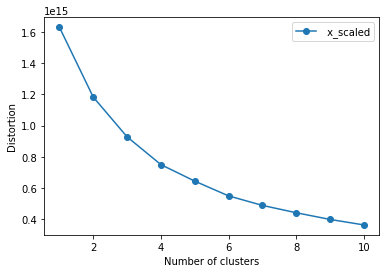

In [159]:
from sklearn.cluster import KMeans
plot_distortion(scaled_df,' x_scaled')

In [194]:
KM_4 = KMeans(n_clusters = 4)
KM_2 = KMeans(n_clusters = 2)
y_res_4 = KM_4.fit_predict(scaled_df)
y_res_2 = KM_2.fit_predict(scaled_df)

In [195]:
user_df['group_4'] = y_res_4
user_df['group_2'] = y_res_2

### PCA to plot

In [196]:
from sklearn.decomposition import PCA

In [197]:
pca = PCA(n_components=3)
pca.fit(scaled_df)
df_reduced = pca.fit_transform(scaled_df)

In [198]:
pca.explained_variance_

array([6.97785527e+10, 5.42829435e+10, 3.62745620e+10])

In [199]:
PCA_df = pd.DataFrame(df_reduced)
PCA_df['clusters_2'] = y_res_2
PCA_df['clusters_4'] = y_res_4

In [184]:
# PCA_df = pd.DataFrame(df_reduced)
# PCA_df['clusters'] = user_df['group'].values
# PCA_df['hierarchical'] = user_df['hierarchical'].values
# PCA_df['hierarchical_2'] = user_df['hierarchical_2'].values

In [200]:
PCA_df

0             1              2  clusters_2  clusters_4
0      535733.408268  1.059302e+06  851126.546317           1           1
1     -350837.789181 -2.419476e+04  -82702.185947           0           2
2       75373.181157  1.102954e+05 -123937.034468           1           1
3      187331.018868  2.792655e+05 -108143.612912           1           1
4      343323.853295  8.376427e+05   44057.914922           1           1
...              ...           ...            ...         ...         ...
10153  265532.852152  1.860707e+04 -128703.518709           1           1
10154  666288.733947 -2.460043e+05  250563.769093           1           0
10155  567265.737239  4.313776e+05 -186430.996586           1           1
10156  -38064.016098  3.820971e+04 -109993.053253           0           2
10157    6701.533962  4.402714e+05  436082.820931           0           3

[10158 rows x 5 columns]

In [210]:
fig = px.scatter_3d(PCA_df, x=0, y=1, z=2,color='clusters_2')
fig.show()

In [202]:
fig = px.scatter_3d(PCA_df, x=0, y=1, z=2,color='clusters_4')
fig.show()

### Hierarchical 

In [207]:
user_df.head()

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561197960265754        1677           82951                  72499   
76561197960268122         213          753768                 128745   
76561197960269041          52           83011                  12827   
76561197960269396         594          203558                  12940   
76561197960270781        1053          464703                 108966   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561197960265754                   1                  1723   
76561197960268122                1352                     0   
76561197960269041                   0                     0   
76561197960269396                   0                     0   
76561197960270781                   0                     0   

                   total_playtime_2week  apps_not_played       top1  \
user                                                                  
76561197960265754                1754.0           1571.0  1085660.0   
76561197960268122               10099.0            123.0      730.0   
76561197960269041                3085.0             24.0      730.0   
76561197960269396                 275.0            253.0    39120.0   
76561197960270781                4265.0            587.0   250820.0   

                        top2    top3  top1_time  top2_time  top3_time  \
user                                                                    
76561197960265754  1286830.0    9900    55133.0     7322.0       5377   
76561197960268122      440.0   21660   652111.0    24175.0      15931   
76561197960269041   379720.0  261640    52333.0    10010.0       5956   
76561197960269396   578080.0  238960    42074.0    10107.0       9012   
76561197960270781  1085660.0     570    53200.0    27288.0      26401   

                   top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
user                                                                         
76561197960265754         3         9         5        0        1        2   
76561197960268122         3        10        37        2        2        0   
76561197960269041         3        15        23        2        4        0   
76561197960269396         3        10        11        0        1        2   
76561197960270781         3        15        42        2        0        1   

                   top_pub  med_pub  low_pub  top_cat  med_cat  low_cat  \
user                                                                      
76561197960265754        0        1        2        6        4       15   
76561197960268122        2        2        0        4        7       20   
76561197960269041        2        4        0        7        9       12   
76561197960269396        0        1        2        2        5       17   
76561197960270781        2        0        1        3        3       16   

                   top_gen  med_gen  low_gen  top_price    top_rec  top_pack  \
user                                                                           
76561197960265754        2        2        5       0.00    80758.0      15.0   
76561197960268122        3        0        2      19.99  2875378.0       7.0   
76561197960269041        3        1        1      64.98  2968728.0       6.0   
76561197960269396        5        2        5      36.99  1307556.0       2.0   
76561197960270781        3        1        2       0.00    94831.0       7.0   

                   num_friends  group_4  group_2  hierarchical_2  \
user                                                               
76561197960265754            0        1        1               0   
76561197960268122          393        2        0               1   
76561197960269041           72        1        1               1   
76561197960269396          125        1        1               0   
76561197960270781   

In [178]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [204]:
ac = AgglomerativeClustering(affinity='euclidean',linkage='ward',n_clusters = 2)
y_2 = ac.fit_predict(user_df.drop(['group_2','group_4'], axis =1))
ac = AgglomerativeClustering(affinity='euclidean',linkage='ward',n_clusters = 3)
y_3 = ac.fit_predict(user_df.drop(['group_2','group_4'], axis =1))


In [205]:
user_df['hierarchical_2'] = y_2

In [206]:
user_df['hierarchical_3'] = y_3

In [1493]:
X = PCA_df[[0,1,2]].values
X

array([[ 535733.40826831, 1059302.37924692,  851126.54631677],
       [-350837.78918127,  -24194.75745985,  -82702.18594733],
       [  75373.18115714,  110295.44601485, -123937.03446769],
       ...,
       [ 567265.73723883,  431377.56941986, -186430.99658579],
       [ -38064.01609812,   38209.70979221, -109993.05325311],
       [   6701.53396222,  440271.42155104,  436082.820931  ]])

In [1472]:
user_df['hierarchical'] = y_hc

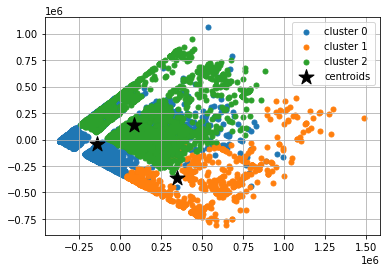

In [1494]:
plot_clusters(X,y_hc, True)

In [1321]:
# define plot_dendrogram function
def plot_dendrogram(X,method ='ward'):
    fig, ax = plt.subplots(figsize=(12,8))
    sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()

In [1505]:
X = user_df.drop(['group','hierarchical'], axis = 1).values
X

array([[1.677000e+03, 8.295100e+04, 7.249900e+04, ..., 8.075800e+04,
        1.500000e+01, 0.000000e+00],
       [2.130000e+02, 7.537680e+05, 1.287450e+05, ..., 2.875378e+06,
        7.000000e+00, 3.930000e+02],
       [5.200000e+01, 8.301100e+04, 1.282700e+04, ..., 2.968728e+06,
        6.000000e+00, 7.200000e+01],
       ...,
       [8.000000e+00, 1.108900e+04, 1.108900e+04, ..., 3.207857e+06,
        5.000000e+00, 2.500000e+01],
       [2.500000e+01, 1.858700e+04, 1.858700e+04, ..., 2.129810e+05,
        4.000000e+00, 4.900000e+01],
       [2.000000e+00, 4.160000e+03, 4.160000e+03, ..., 2.107470e+05,
        3.000000e+00, 1.000000e+00]])

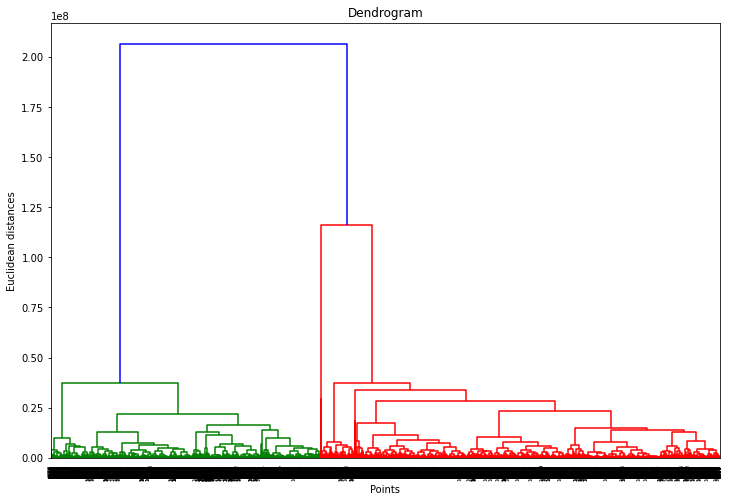

In [1506]:
plot_dendrogram(X)

In [ ]:
X = PCA_df[[0,1,2]].values
X

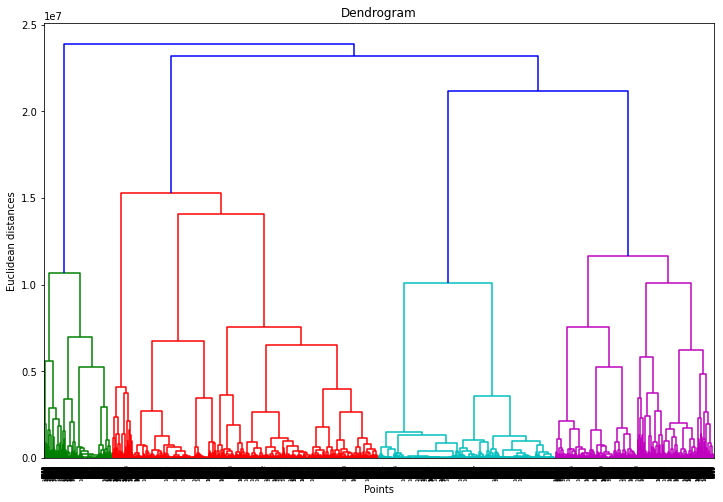

In [1495]:
plot_dendrogram(X)

In [ ]:
X = PCA_df[[0,1]].values
X

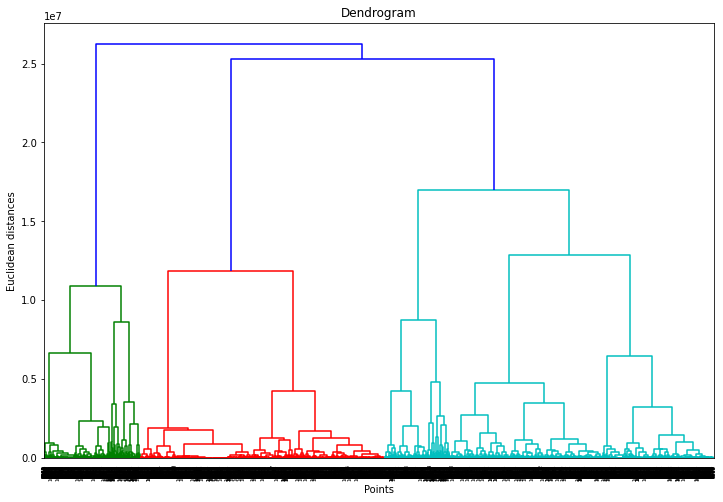

In [1322]:
plot_dendrogram(X)

### DBSCAN

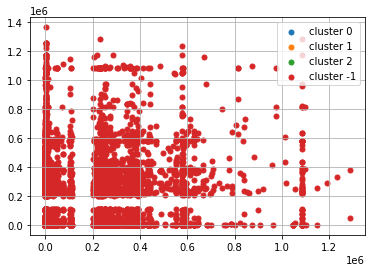

In [1113]:
# PCA_df.drop('clusters', axis =1, inplace = True)
db = DBSCAN(eps = 4, min_samples = 30, metric= 'euclidean')
y_db = db.fit_predict(scaled_df.values)
plot_clusters(scaled_df.values,y_db)

In [1514]:
user_df

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561197960265754        1677           82951                  72499   
76561197960268122         213          753768                 128745   
76561197960269041          52           83011                  12827   
76561197960269396         594          203558                  12940   
76561197960270781        1053          464703                 108966   
...                       ...             ...                    ...   
76561199068541494           4            4706                   4706   
76561199069688064          50           24220                  24220   
76561199072788332           8           11089                  11089   
76561199076436762          25           18587                  18587   
76561199084057479           2            4160                   4160   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561197960265754                   1                  1723   
76561197960268122                1352                     0   
76561197960269041                   0                     0   
76561197960269396                   0                     0   
76561197960270781                   0                     0   
...                               ...                   ...   
76561199068541494                   0                     0   
76561199069688064                   0                     0   
76561199072788332                   0                     0   
76561199076436762                   0                     0   
76561199084057479                   0                     0   

                   total_playtime_2week  apps_not_played       top1  \
user                                                                  
76561197960265754                1754.0           1571.0  1085660.0   
76561197960268122               10099.0            123.0      730.0   
76561197960269041                3085.0             24.0      730.0   
76561197960269396                 275.0            253.0    39120.0   
76561197960270781                4265.0            587.0   250820.0   
...                                 ...              ...        ...   
76561199068541494                  52.0              0.0      730.0   
76561199069688064                2113.0             18.0   381210.0   
76561199072788332                2518.0              0.0      730.0   
76561199076436762                2159.0             13.0      440.0   
76561199084057479                2143.0              0.0   582010.0   

                        top2    top3  top1_time  top2_time  top3_time  \
user                                                                    
76561197960265754  1286830.0    9900    55133.0     7322.0       5377   
76561197960268122      440.0   21660   652111.0    24175.0      15931   
76561197960269041   379720.0  261640    52333.0    10010.0       5956   
76561197960269396   578080.0  238960    42074.0    10107.0       9012   
76561197960270781  1085660.0     570    53200.0    27288.0      26401   
...                      ...     ...        ...        ...        ...   
76561199068541494   431960.0  466240     3821.0      605.0        166   
76561199069688064   444090.0  945360     5620.0     3077.0       2993   
76561199072788332   945360.0  431960     9256.0     1469.0        117   
76561199076436762   250820.0  221100    12242.0     2933.0       1667   
76561199084057479   524220.0       0     4101.0       59.0          0   

                   top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
user                                                                         
76561197960265754         3         9         5        0        1        2   
76561197960268122         3        10        37        2        2        0   
76561197960269041         3        15        23        2        4        0  

<AxesSubplot:xlabel='total_playtime'>

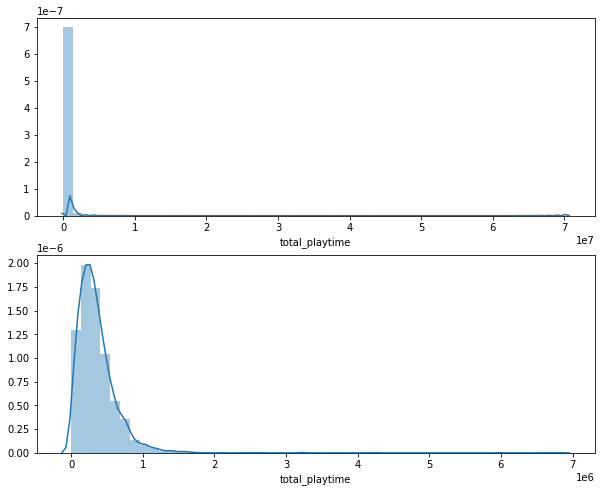

In [1518]:
#plot clusters
fig, ax = plt.subplots(2,figsize=(10,8))
sns.distplot(user_df[user_df['hierarchical_2']==0]['total_playtime'], ax = ax[0])
sns.distplot(user_df[user_df['hierarchical_2']==1]['total_playtime'], ax = ax[1])
# sns.distplot(user_df[user_df['hierarchical']==2]['total_playtime'], ax = ax[2])

<AxesSubplot:xlabel='apps_owned'>

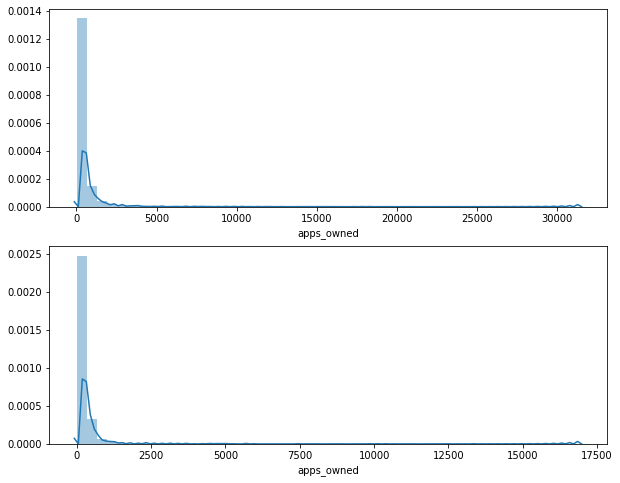

In [1519]:
#plot clusters
fig, ax = plt.subplots(2,figsize=(10,8))
sns.distplot(user_df[user_df['hierarchical_2']==0]['apps_owned'], ax = ax[0])
sns.distplot(user_df[user_df['hierarchical_2']==1]['apps_owned'], ax = ax[1])
# sns.distplot(user_df[user_df['hierarchical']==2]['apps_owned'], ax = ax[2])

In [1522]:
user_df

apps_owned  total_playtime  total_window_playtime  \
user                                                                   
76561197960265754        1677           82951                  72499   
76561197960268122         213          753768                 128745   
76561197960269041          52           83011                  12827   
76561197960269396         594          203558                  12940   
76561197960270781        1053          464703                 108966   
...                       ...             ...                    ...   
76561199068541494           4            4706                   4706   
76561199069688064          50           24220                  24220   
76561199072788332           8           11089                  11089   
76561199076436762          25           18587                  18587   
76561199084057479           2            4160                   4160   

                   total_mac_playtime  total_linux_playtime  \
user                                                          
76561197960265754                   1                  1723   
76561197960268122                1352                     0   
76561197960269041                   0                     0   
76561197960269396                   0                     0   
76561197960270781                   0                     0   
...                               ...                   ...   
76561199068541494                   0                     0   
76561199069688064                   0                     0   
76561199072788332                   0                     0   
76561199076436762                   0                     0   
76561199084057479                   0                     0   

                   total_playtime_2week  apps_not_played       top1  \
user                                                                  
76561197960265754                1754.0           1571.0  1085660.0   
76561197960268122               10099.0            123.0      730.0   
76561197960269041                3085.0             24.0      730.0   
76561197960269396                 275.0            253.0    39120.0   
76561197960270781                4265.0            587.0   250820.0   
...                                 ...              ...        ...   
76561199068541494                  52.0              0.0      730.0   
76561199069688064                2113.0             18.0   381210.0   
76561199072788332                2518.0              0.0      730.0   
76561199076436762                2159.0             13.0      440.0   
76561199084057479                2143.0              0.0   582010.0   

                        top2    top3  top1_time  top2_time  top3_time  \
user                                                                    
76561197960265754  1286830.0    9900    55133.0     7322.0       5377   
76561197960268122      440.0   21660   652111.0    24175.0      15931   
76561197960269041   379720.0  261640    52333.0    10010.0       5956   
76561197960269396   578080.0  238960    42074.0    10107.0       9012   
76561197960270781  1085660.0     570    53200.0    27288.0      26401   
...                      ...     ...        ...        ...        ...   
76561199068541494   431960.0  466240     3821.0      605.0        166   
76561199069688064   444090.0  945360     5620.0     3077.0       2993   
76561199072788332   945360.0  431960     9256.0     1469.0        117   
76561199076436762   250820.0  221100    12242.0     2933.0       1667   
76561199084057479   524220.0       0     4101.0       59.0          0   

                   top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
user                                                                         
76561197960265754         3         9         5        0        1        2   
76561197960268122         3        10        37        2        2        0   
76561197960269041         3        15        23        2        4        0  

### hierarchical_2

In [1520]:
print(st.mode(user_df[user_df['hierarchical_2']==0]['top1']))
print(st.mode(user_df[user_df['hierarchical_2']==0]['top2']))
print(st.mode(user_df[user_df['hierarchical_2']==0]['top3']))
print(np.mean(user_df[user_df['hierarchical_2']==0]['apps_not_played']))
print(np.mean(user_df[user_df['hierarchical_2']==0]['top_price']))
print(np.mean(user_df[user_df['hierarchical_2']==0]['num_friends']))

440.0
440.0
440
260.60313531353137
44.78512541254126
123.43151815181518


In [1521]:
print(st.mode(user_df[user_df['hierarchical_2']==1]['top1']))
print(st.mode(user_df[user_df['hierarchical_2']==1]['top2']))
print(st.mode(user_df[user_df['hierarchical_2']==1]['top3']))
print(np.mean(user_df[user_df['hierarchical_2']==1]['apps_not_played']))
print(np.mean(user_df[user_df['hierarchical_2']==1]['top_price']))
print(np.mean(user_df[user_df['hierarchical_2']==1]['num_friends']))

730.0
730.0
730
119.48413860419717
30.03655929721816
157.0261102977062


### Group

In [1487]:
print(st.mode(user_df[user_df['group']==0]['top1']))
print(st.mode(user_df[user_df['group']==0]['top2']))
print(st.mode(user_df[user_df['group']==0]['top3']))
print(np.mean(user_df[user_df['group']==0]['apps_not_played']))
print(np.mean(user_df[user_df['group']==0]['top_price']))
print(np.mean(user_df[user_df['group']==0]['num_friends']))

730.0
578080.0
730
284.19249028916704
47.77087181700475
133.1238670694864


In [1488]:
print(st.mode(user_df[user_df['group']==1]['top1']))
print(st.mode(user_df[user_df['group']==1]['top2']))
print(st.mode(user_df[user_df['group']==1]['top3']))
print(np.mean(user_df[user_df['group']==1]['apps_not_played']))
print(np.mean(user_df[user_df['group']==1]['top_price']))
print(np.mean(user_df[user_df['group']==1]['num_friends']))

730.0
730.0
730
183.46687697160883
33.82510210858376
138.78532292877304


In [1489]:
print(st.mode(user_df[user_df['group']==2]['top1']))
print(st.mode(user_df[user_df['group']==2]['top2']))
print(st.mode(user_df[user_df['group']==2]['top3']))
print(np.mean(user_df[user_df['group']==2]['apps_not_played']))
print(np.mean(user_df[user_df['group']==2]['top_price']))
print(np.mean(user_df[user_df['group']==2]['num_friends']))

730.0
730.0
578080
167.990099009901
44.04509350935094
135.93839383938393


In [209]:
# user_df.to_csv(data_path+'user_FE.csv')

In [211]:
pd.read_csv(data_path+'user_FE.csv', header=0)

user  apps_owned  total_playtime  total_window_playtime  \
0      76561197960265754        1677           82951                  72499   
1      76561197960268122         213          753768                 128745   
2      76561197960269041          52           83011                  12827   
3      76561197960269396         594          203558                  12940   
4      76561197960270781        1053          464703                 108966   
...                  ...         ...             ...                    ...   
10153  76561199068541494           4            4706                   4706   
10154  76561199069688064          50           24220                  24220   
10155  76561199072788332           8           11089                  11089   
10156  76561199076436762          25           18587                  18587   
10157  76561199084057479           2            4160                   4160   

       total_mac_playtime  total_linux_playtime  total_playtime_2week  \
0                       1                  1723                1754.0   
1                    1352                     0               10099.0   
2                       0                     0                3085.0   
3                       0                     0                 275.0   
4                       0                     0                4265.0   
...                   ...                   ...                   ...   
10153                   0                     0                  52.0   
10154                   0                     0                2113.0   
10155                   0                     0                2518.0   
10156                   0                     0                2159.0   
10157                   0                     0                2143.0   

       apps_not_played       top1       top2    top3  top1_time  top2_time  \
0               1571.0  1085660.0  1286830.0    9900    55133.0     7322.0   
1                123.0      730.0      440.0   21660   652111.0    24175.0   
2                 24.0      730.0   379720.0  261640    52333.0    10010.0   
3                253.0    39120.0   578080.0  238960    42074.0    10107.0   
4                587.0   250820.0  1085660.0     570    53200.0    27288.0   
...                ...        ...        ...     ...        ...        ...   
10153              0.0      730.0   431960.0  466240     3821.0      605.0   
10154             18.0   381210.0   444090.0  945360     5620.0     3077.0   
10155              0.0      730.0   945360.0  431960     9256.0     1469.0   
10156             13.0      440.0   250820.0  221100    12242.0     2933.0   
10157              0.0   582010.0   524220.0       0     4101.0       59.0   

       top3_time  top_lang  med_lang  low_lang  top_dev  med_dev  low_dev  \
0           5377         3         9         5        0        1        2   
1          15931         3        10        37        2        2        0   
2           5956         3        15        23        2        4        0   
3           9012         3        10        11        0        1        2   
4          26401         3        15        42        2        0        1   
...          ...       ...       ...       ...      ...      ...      ...   
10153        166         3        15        38        1        1        2   
10154       2993         3         9        12        0        0        3   
10155        117         3        11        32        1        1        2   
10156       1667         3        15        41        3        0        0   
10157          0         2         9         6        1        1        1   

       top_pub  med_pub  low_pub  top_cat  med_cat  low_cat  top_gen  med_gen  \
0            0        1        2        6        4       15        2        2   
1            2        2        0        4        7       20        3        0   
2            2        4        0        7        9       12        3        1   
3       